In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pydicom
from data_pipeline.image_transforms import  get_transforms
import input_mapping.models_torch as models_torch
import json
from PIL import Image
from tqdm import tqdm

In [2]:
#read in the data
diagnosis_df = pd.read_excel('~/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx')
diagnosis_df.head()

,Diagnose,CFP,Index
0,Morbus Stargardt,True,1
1,Morbus Stargardt,True,2
2,Morbus Stargardt,True,3
3,PXE,True,4
4,PXE,False,5


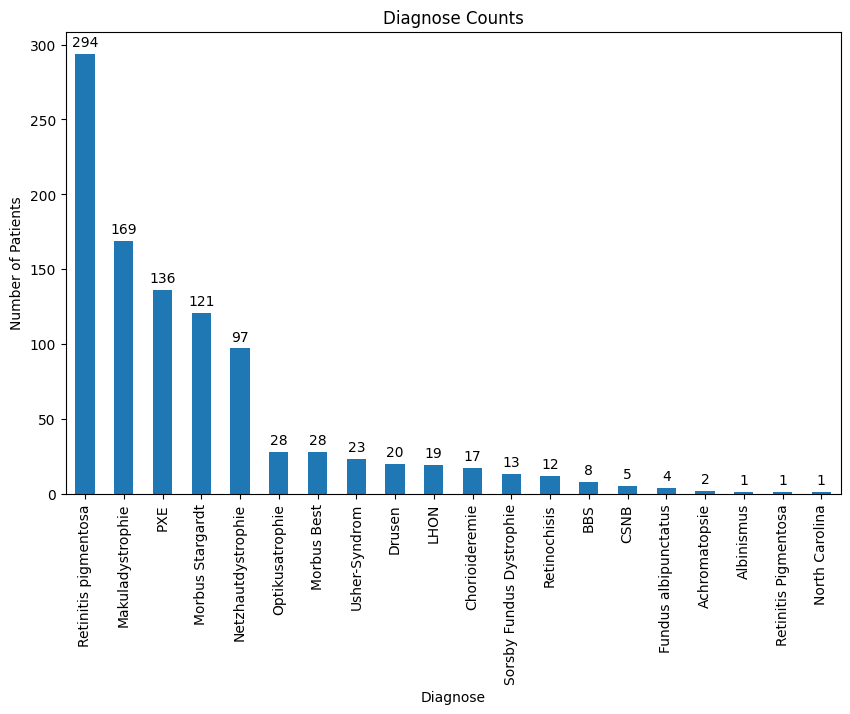

Diagnose
Retinitis pigmentosa        294
Makuladystrophie            169
PXE                         136
Morbus Stargardt            121
Netzhautdystrophie           97
Optikusatrophie              28
Morbus Best                  28
Usher-Syndrom                23
Drusen                       20
LHON                         19
Chorioideremie               17
Sorsby Fundus Dystrophie     13
Retinochisis                 12
BBS                           8
CSNB                          5
Fundus albipunctatus          4
Achromatopsie                 2
Albinismus                    1
Retinitis Pigmentosa          1
North Carolina                1
Name: count, dtype: int64


In [3]:
diagnosis_df['Diagnose'] = diagnosis_df.Diagnose.str.strip()
#count the Diagnosen
diagnosis_counts = diagnosis_df['Diagnose'].value_counts()
plt.figure(figsize=(10,6))
#create a bar plot which shows the number of each Diagnose
diagnosis_counts.plot(kind='bar')
plt.title('Diagnose Counts')
plt.xlabel('Diagnose')
plt.ylabel('Number of Patients')
plt.xticks(rotation=90)
for i, v in enumerate(diagnosis_counts):
    plt.text(i, v + 5, str(v), ha='center')
plt.show()

print(diagnosis_counts)

In [4]:
#filter to Retinitis pigmentosa, Morbus Stargardt, Morbus Best
diagnosis_df = diagnosis_df[diagnosis_df['Diagnose'].isin(['Retinitis pigmentosa', 'Morbus Stargardt', 'Morbus Best'])]
#count the Diagnosen
diagnosis_df['Diagnose'].value_counts()

Diagnose
Retinitis pigmentosa    294
Morbus Stargardt        121
Morbus Best              28
Name: count, dtype: int64

In [5]:
diagnosis_df.head()

,Diagnose,CFP,Index
0,Morbus Stargardt,True,1
1,Morbus Stargardt,True,2
2,Morbus Stargardt,True,3
18,Morbus Best,False,19
25,Retinitis pigmentosa,True,26


In [6]:
#todos
'''
1. upload the two best trained models
2. read in data with label (create dataloader read from a table which has a file path and a label
create a function that creates this table from the dataset folder structure and the excel sheet with the labels)
3. filter the data to the three Diagnosen
2. execute on filtered data
3. evaluate the results
'''

'\n1. upload the two best trained models\n2. read in data with label (create dataloader read from a table which has a file path and a label\ncreate a function that creates this table from the dataset folder structure and the excel sheet with the labels)\n3. filter the data to the three Diagnosen\n2. execute on filtered data\n3. evaluate the results\n'

In [7]:
def find_files(folder_path):
    """
    Recursively find all files in a folder and its subfolders.
    
    Args:
    - folder_path (str): Path to the folder to search.
    
    Returns:
    - file_paths (list): List of paths to all files found.
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [8]:
diagnosis_df.head()

,Diagnose,CFP,Index
0,Morbus Stargardt,True,1
1,Morbus Stargardt,True,2
2,Morbus Stargardt,True,3
18,Morbus Best,False,19
25,Retinitis pigmentosa,True,26


In [9]:
data_list = []
for i, patient in diagnosis_df.iterrows():
    #format the patient index to a number with leading zeros
    patient_index = str(patient['Index']).zfill(4)
    #searth for the patient folder
    file_paths = find_files(f'/home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/{patient_index}')
    for file_path in file_paths:
        data_list.append([patient['Diagnose'], file_path, patient_index])
data_df = pd.DataFrame(data_list, columns=['label', 'file_path', 'patient_index'])
data_df.head()	


,label,file_path,patient_index
0,Morbus Stargardt,/home/efarjall/ird_dataset/export_heyex_origin...,0001
1,Morbus Stargardt,/home/efarjall/ird_dataset/export_heyex_origin...,0001
2,Morbus Stargardt,/home/efarjall/ird_dataset/export_heyex_origin...,0002
3,Morbus Stargardt,/home/efarjall/ird_dataset/export_heyex_origin...,0002
4,Morbus Stargardt,/home/efarjall/ird_dataset/export_heyex_origin...,0002


In [10]:
#replace Morbus Best with Best Disease and Morbus Stargardt with Stargardt
data_df['label'] = data_df['label'].replace('Morbus Best', 'Best Disease')
data_df['label'] = data_df['label'].replace('Morbus Stargardt', 'Stargardt Disease')
data_df['label'] = data_df['label'].replace('Retinitis pigmentosa', 'Retinitis Pigmentosa')


In [11]:
#load the dataset configuration
with open('datasets/2024-02-23-13-31-39/dataset_config.json') as json_file:
    dataset_config = json.load(json_file)
label_names = dataset_config['label_names']
#add each label as a column to the dataframe
for label in label_names:
    data_df[label] = 0
#set the label column to 1 for the corresponding label
for i, row in data_df.iterrows():
    data_df.at[i, row['label']] = 1
#make all labels integers
data_df[label_names] = data_df[label_names].astype(int)

In [12]:
data_df.head()

,label,file_path,patient_index,Age-related Macular Degeneration,Best Disease,Bietti crystalline dystrophy,cataract,Cone Dystrophie or Cone-rod Dystrophie,Diabetic Retinopathy,glaucoma,Maculopathy,Myopia,Normal,Retinitis Pigmentosa,Stargardt Disease
0,Stargardt Disease,/home/efarjall/ird_dataset/export_heyex_origin...,0001,0,0,0,0,0,0,0,0,0,0,0,1
1,Stargardt Disease,/home/efarjall/ird_dataset/export_heyex_origin...,0001,0,0,0,0,0,0,0,0,0,0,0,1
2,Stargardt Disease,/home/efarjall/ird_dataset/export_heyex_origin...,0002,0,0,0,0,0,0,0,0,0,0,0,1
3,Stargardt Disease,/home/efarjall/ird_dataset/export_heyex_origin...,0002,0,0,0,0,0,0,0,0,0,0,0,1
4,Stargardt Disease,/home/efarjall/ird_dataset/export_heyex_origin...,0002,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
#filter out the dicom files that do not have pixel data
data_df['has_pixel_data'] = False
for i, row in data_df.iterrows():
    try:
        dicom = pydicom.dcmread(row['file_path'])
        dicom.pixel_array
        data_df.at[i, 'has_pixel_data'] = True
    except:
        print(f'No pixel data for {row["file_path"]}')
        pass
data_df = data_df[data_df['has_pixel_data']]

No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681240/00000032
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681241/00000013
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681241/00000014
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681241/00000015
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681241/00000016
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681242/00000005
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681243/00000002
No pixel data for /home/efarjall/ird_dataset/export_heyex_original_dataset_03/DICOM/0089/85121/417197/8681244/00000001
No pixel data for /home/efarjall/ird_dataset/exp

In [14]:
class DICOMDataset(Dataset):
    def __init__(self, data_df, transform=None, label_cols=label_names):
        self.data_df = data_df
        self.transform = transform
        self.label_cols = label_cols
    def __len__(self):
        return len(self.data_df)
    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        file_path = row['file_path']
        img_array = pydicom.dcmread(file_path).pixel_array
        img = Image.fromarray(img_array).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.Tensor(row[self.label_cols].values.astype(np.int8)).float()
        return img, label

In [15]:
img_array = pydicom.dcmread(data_df.iloc[0]['file_path']).pixel_array
print(type(img_array))
img_array.dtype

<class 'numpy.ndarray'>


dtype('uint8')

In [16]:
transform_config = models_torch.model_dict['resnet18']['transforms_config']
ben_transformer = get_transforms('ben', transform_config)
standard_transformer = get_transforms('standard', transform_config)

ben_dataset = DICOMDataset(data_df, ben_transformer)
standard_dataset = DICOMDataset(data_df, standard_transformer)

dataloader_ben = DataLoader(ben_dataset, batch_size=1024, shuffle=False)
dataloader_standard = DataLoader(standard_dataset, batch_size=1024, shuffle=False)


In [17]:
model_ben = models_torch.get_model('resnet18', 12)
model_standard = models_torch.get_model('resnet18', 12)

model_ben.load_state_dict(torch.load('best_models_for_dataset/2024-02-23-13-31-39/resnet18/best_model_ben/best_model.pt'))
model_standard.load_state_dict(torch.load('best_models_for_dataset/2024-02-23-13-31-39/resnet18/best_model_standard/best_model.pt'))

/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/efarjall/miniconda3/envs/ird/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

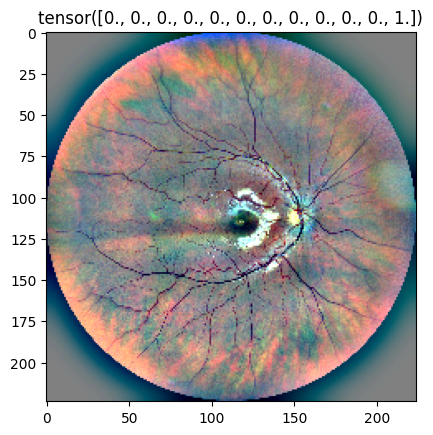

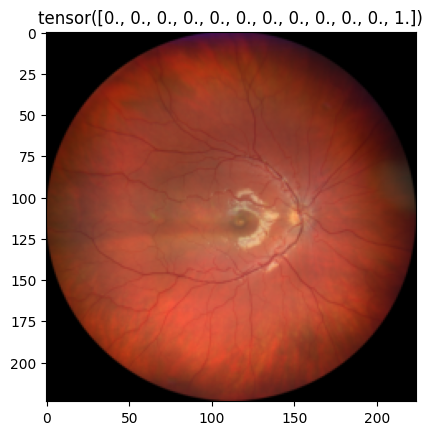

In [18]:
#show an image
img, label = ben_dataset[0]
plt.imshow(img.permute(1, 2, 0))
plt.title(label)
plt.show()

img2, label = standard_dataset[0]
plt.imshow(img2.permute(1, 2, 0))
plt.title(label)
plt.show()

In [19]:
#execute the models on the data
def execute_model(model, dataloader):
    model.eval()
    #move the model to the device
    device = torch.device('cuda:0') #if torch.cuda.is_available() else 'cpu')
    model.to(device)
    predictions = []
    labels = []
    #create a progress bar
    with torch.no_grad():
        for img, label in tqdm(dataloader):
            label = label.to(device)
            img = img.to(device)
            output = model(img)
            predictions.append(output.detach().cpu())
            labels.append(label.cpu())
            #update the progress bar
    return predictions, labels

In [20]:
#execute the models

predictions_ben, labels = execute_model(model_ben, dataloader_ben)
predictions_standard, _ = execute_model(model_standard, dataloader_standard)


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [02:31<00:00, 75.60s/it] 


In [21]:
#flatten the predictions and labels
predictions_ben = np.concatenate(predictions_ben)
predictions_standard = np.concatenate(predictions_standard)
labels = np.concatenate(labels)


In [53]:
from ai_backend.evaluators.metrics.multi_label_metrics import multi_label_accuracy, multi_label_precision, multi_label_f_beta, multi_label_recal, multi_label_confusion_matrix
ben_thresholds = np.array([0.5700, 0.0100, 0.0600, 0.1700, 0.1800, 0.2500, 0.5100, 0.2300, 0.9300,
        0.2900, 0.2700, 0.0200])
standard_thresholds = np.array([0.1000, 0.0800, 0.1400, 0.8000, 0.0600, 0.5800, 0.4600, 0.9400, 0.7300,
        0.6700, 0.6700, 0.0300])
predictions_ben = torch.Tensor(predictions_ben)
predictions_standard = torch.Tensor(predictions_standard)
labels = torch.Tensor(labels)
ben_precision = multi_label_precision(y_true=labels, y_pred=predictions_ben, threshold=ben_thresholds)
ben_f1 = multi_label_f_beta(y_true=labels, y_pred=predictions_ben, threshold=ben_thresholds, beta=1)
ben_recall = multi_label_recal(y_true=labels, y_pred=predictions_ben, threshold=ben_thresholds)
print(f'Ben Precision: {ben_precision}')
print(f'Ben Recall: {ben_recall}')
print(f'Ben F1: {ben_f1}')

standard_predictions = torch.Tensor(predictions_standard)
standard_precision = multi_label_precision(y_true=labels, y_pred=standard_predictions, threshold=standard_thresholds)
standard_f1 = multi_label_f_beta(y_true=labels, y_pred=standard_predictions, threshold=standard_thresholds, beta=1)
standard_recall = multi_label_recal(y_true=labels, y_pred=standard_predictions, threshold=standard_thresholds)
print(f'Standard Precision: {standard_precision}')
print(f'Standard Recall: {standard_recall}')
print(f'Standard F1: {standard_f1}')

Ben Precision: [0.         0.03925234 0.         0.         0.         0.
 0.         0.         0.         0.         0.75607477 0.2046729 ]
Ben Recall: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Ben F1: [0.         0.07553957 0.         0.         0.         0.
 0.         0.         0.         0.         0.86109633 0.33979829]
Standard Precision: [0.         0.03925234 0.         0.         0.         0.
 0.         0.         0.         0.         0.98780488 0.2046729 ]
Standard Recall: [0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.20024722 1.        ]
Standard F1: [0.         0.07553957 0.         0.         0.         0.
 0.         0.         0.         0.         0.33299075 0.33979829]


/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
/home/efarjall/IRD-DeepLearning/ai_backend/evaluators/metrics/multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_

In [51]:
ben_cm = multi_label_confusion_matrix(y_true=labels, y_pred=predictions_ben, threshold=ben_thresholds)
print(ben_cm)

[{'true_negatives': 1012, 'false_positives': 58, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 1026, 'false_positives': 2, 'false_negatives': 41, 'true_positvies': 1}, {'true_negatives': 1068, 'false_positives': 2, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 1041, 'false_positives': 29, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 1058, 'false_positives': 12, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 891, 'false_positives': 179, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 934, 'false_positives': 136, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 1070, 'false_positives': 0, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 903, 'false_positives': 167, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 986, 'false_positives': 84, 'false_negatives': 0, 'true_positvies': 0}, {'true_negatives': 261, 'false_positives': 0, 'false_negatives': 670, 'true_positv